<a href="https://colab.research.google.com/github/jdmartinev/ST1613-AppliedML-/blob/main/Semana02/Preprocesamiento_de_datos_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semana 2 - Preprocesamiento de datos**

## **Objetivos de aprendizaje**

- Reconocer el impacto de la calidad y cantidad de datos en los algoritmos de ML
- Explicar un proceso típico de recolección y transformación de datos en el flujo de trabajo de ML
- Identificar cuando implementar transformaciones de características como imputación, escalamiento, one-hot-encoding

## **Ejemplo 1: Recomendación de canciones usando $k$-NN**

En este ejemplo usaremos $k-$NN para predecir si a un usuario le gustará una canción o no.

Intuición: 

- Encuentre las canciones similares en el conjunto de entrenamiento a la canción a la que queremos hacer la predicción 
- Por mayoría, escoger si al usuario le gustaron o no estas canciones
- Asignar la etiqueta a la nueva canción según el voto mayoritario

![Spotify recommendation](https://drive.google.com/uc?id=18lBxaBGX3n8BPxwyOnybK2CqtMHDp9Up)



## **Descarga de datos (opción 1)**

Lo primero que hará será descargar los datos con los que va a trabajar:

- Tabla de datos de clientes (archivo csv).

Este archivo quedará en la ruta _/content/data.csv asociada con el sistema operativo del servidor en el que se está ejecutando google colab.

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UAeE2IQvuFxvwep1ThK7_DnpBfUB7eyr' -O data_spotify.csv



--2023-04-11 22:28:42--  https://docs.google.com/uc?export=download&id=1UAeE2IQvuFxvwep1ThK7_DnpBfUB7eyr
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2sulapke543dhkjhd68jc60a3htkm2es/1681252050000/15315348669826032119/*/1UAeE2IQvuFxvwep1ThK7_DnpBfUB7eyr?e=download&uuid=487e2372-1ad3-4d0d-a7c9-428c161de1e1 [following]
--2023-04-11 22:28:43--  https://doc-08-6c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2sulapke543dhkjhd68jc60a3htkm2es/1681252050000/15315348669826032119/*/1UAeE2IQvuFxvwep1ThK7_DnpBfUB7eyr?e=download&uuid=487e2372-1ad3-4d0d-a7c9-428c161de1e1
Resolving doc-08-6c-docs.googleusercontent.com (doc-08-6c-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:

## **Descarga de datos (opción 2)**

Vincular google colab con google drive

https://www.youtube.com/watch?v=6UnCrulz-fE



## **Importar librerías necesarias**

In [ ]:
import sys
import time

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")

#import mglearn
from IPython.display import display
#from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#from utils import *

pd.set_option("display.max_colwidth", 200)

## **Entrenamiento del modelo**


In [ ]:
# Cargar los datos
spotify_df = pd.read_csv("data_spotify.csv", index_col=0)
spotify_df.head()

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062             4.0    0.286   
1    0.1370   -10.401     1       0.0794  160.083             4.0    0.588   
2    0.1590    -7.148     1       0.2890   75.044             4.0    0.173   
3    0.0922   -15.236     1       0.0261   86.468             4.0    0.230   
4    0.4390   -11.648     0       0.0694  174.004             4.0    0.904   

   target      song_title            artist  
0       1        Mask Off            Future  
1       1         Redbone  Childish Gambino  
2       1    Xanny Family            Future  
3       1  Master Of None       Beach House  
4       1  Parallel Lines       Junior Boys

In [ ]:
#Particiones de entrenamiento, validación y prueba
train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)
train_df, val_df = train_test_split(train_df, test_size = 0.20, random_state=123)


In [ ]:
#Definir variable objetivo y eliminar variables no numéricas
X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)

X_val, y_val = (
    val_df.drop(columns=["song_title", "artist", "target"]),
    val_df["target"],
)

X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)


In [ ]:
# Crear un clasificador KNN con diferentes números de vecinos
n_neighbors = [1,3,5,7,9,11,13,15]
accuracy = []

for k in n_neighbors:
  clf = Pipeline(steps=[("classifier", KNeighborsClassifier(n_neighbors=k))])

  # Entrenar el clasificador con los datos de entrenamiento
  clf.fit(X_train, y_train)

  # Evaluar el rendimiento del clasificador en los datos de validación
  accuracy.append(clf.score(X_val, y_val))

[Text(0.5, 0, 'Number of neighbors'),
 Text(0, 0.5, 'Accuracy (%)'),
 Text(0.5, 1.0, 'k-NN Classification')]

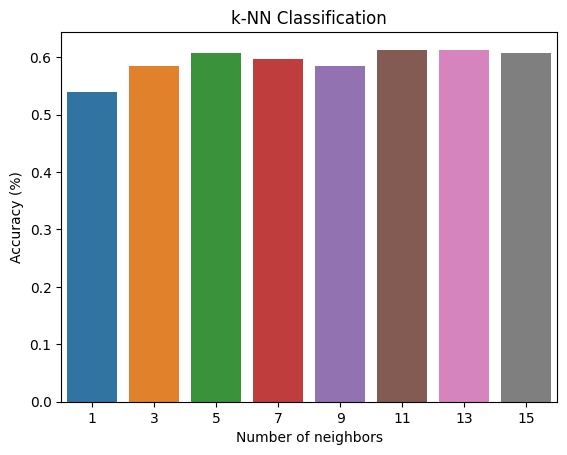

In [ ]:
gfg = sns.barplot(x = n_neighbors,y = accuracy)
gfg.set(xlabel ="Number of neighbors", ylabel = "Accuracy (%)", title ='k-NN Classification')

In [ ]:
#Re-entrenar el modelo con los datos de entrenamiento y validación para el valor de k óptimo
k_opt = n_neighbors[np.argmax(accuracy)]
print(f"El número óptimo de vecinos es {k_opt}")
X_train_test = pd.concat([X_train,X_val],axis=0)
y_train_test = np.hstack([y_train,y_val])

clf = Pipeline(steps=[("classifier", KNeighborsClassifier(n_neighbors=k_opt))])
clf.fit(X_train_test, y_train_test)
#Validar el rendimiento del clasificador con los datos de prueba
accuracy = clf.score(X_test, y_test)

print(f"La tasa de acierto de clasificación en el conjunto de test es {accuracy:0.2f}")

El número óptimo de vecinos es 11
La tasa de acierto de clasificación en el conjunto de test es 0.56


## ¿Cómo se calculan los vecinos más cercanos?

Notación matemática:

Cada fila de un dataframe será para nosotros un vector de n posiciones (vector de características):

$\mathbf{x}^{(i)} = \begin{bmatrix}
x_1^{(i)} \\
x_2^{(i)} \\
\vdots \\
x_n^{(i)}
\end{bmatrix} \in \Re^{n}$

El super-índice (i) denota la fila del dataframe

La distancia euclidiana sirve para saber qué tan lejos o cerca están dos vectores de características. Se calcula de la siguiente forma: 

$d(\mathbf{x}^{(1)},\mathbf{x}^{(2)}) = \sqrt{(x_1^{(1)} - x_1^{(2)})^2 + (x_2^{(1)} - x_2^{(2)})^2 + ... + (x_n^{(1)} - x_n^{(2)})^2}$

In [ ]:
#Tomemos dos filas del dataframe y calculemos la distancia euclidiana
two_songs = X_train.sample(2, random_state=42)
two_songs

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
1890        0.1600         0.561       295493   0.555          0.000000   11   
1351        0.0145         0.716       215253   0.972          0.000032    7   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  
1890     0.114    -9.734     0       0.0287  134.369             4.0    0.509  
1351     0.317    -2.302     1       0.1960  110.026             4.0    0.566

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
dist_matrix = squareform(pdist(two_songs, metric='euclidean'))
print(dist_matrix)

[[    0.         80240.00414449]
 [80240.00414449     0.        ]]


In [ ]:
#Consideremos ahora únicamente dos características (distancia y tiempo)
two_songs_subset = two_songs[["duration_ms", "tempo"]]
two_songs_subset

duration_ms    tempo
1890       295493  134.369
1351       215253  110.026

In [ ]:
dist_matrix = squareform(pdist(two_songs_subset, metric='euclidean'))
print(dist_matrix)

[[    0.         80240.00369256]
 [80240.00369256     0.        ]]


¿Encontramos algún problema?

- La distancia está completamente dominada por las características con valores más grandes.
- Las características con valores más pequeños están siendo ignoradas.
- ¿Importa?
  - ¡Sí! La escala se basa en cómo se recopilaron los datos.
  - Las características en una escala más pequeña pueden ser altamente informativas y no hay una buena razón para ignorarlas.
  - Queremos que nuestro modelo sea robusto y no sea sensible a la escala.

Este problema aplica para todos los modelos que usan distancias en su formulación, regresión lineal, logística, redes neuronales.

¡No aplica para modelos basados en árboles de decisión!

### Escalamiento usando [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de `scikit-learn`

- Utilizaremos [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) de `scikit-learn`, que es un `transformer`.   
- Por ahora nos centraremos en la sintaxis. 

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # Crear objeto transformador de características
scaler.fit(X_train)  # ajustar el transformador en la división de entrenamiento
X_train_scaled = scaler.transform(X_train)  # transformar la división de entrenamiento
X_val_scaled = scaler.transform(X_val)   # transformar la división de validación
X_test_scaled = scaler.transform(X_test)  # transformar la división de prueba

In [ ]:
X_train

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
432        0.19800         0.507       286413   0.739          0.865000    2   
1673       0.11400         0.858       290836   0.697          0.000000    2   
1172       0.02350         0.667       172893   0.648          0.000015    3   
961        0.08530         0.864       126467   0.552          0.778000    5   
1964       0.00513         0.685       267947   0.948          0.003470    9   
...            ...           ...          ...     ...               ...  ...   
1967       0.00141         0.895       179000   0.883          0.000383    7   
1417       0.04150         0.370       250240   0.870          0.000000    5   
575        0.00470         0.777       309180   0.688          0.690000    8   
686        0.35600         0.667       234994   0.901          0.003930    9   
1178       0.01300         0.853       206693   0.560          0.000000    1   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  
432     0.1850    -9.728     1       0.0400   87.569             4.0    0.170  
1673    0.2240    -5.361     1       0.2300   98.012             4.0    0.365  
1172    0.0427    -6.398     0       0.0626   95.031             4.0    0.585  
961     0.0940    -8.851     0       0.0495  112.378             4.0    0.740  
1964    0.1700    -5.182     1       0.0457  104.881             4.0    0.627  
...        ...       ...   ...          ...      ...             ...      ...  
1967    0.2740    -8.919     1       0.2160  131.644             4.0    0.893  
1417    0.6040    -2.090     1       0.2710   79.092             4.0    0.334  
575     0.0960    -8.692     0       0.0681  126.019             4.0    0.180  
686     0.0774    -3.719     0       0.0275  140.026             4.0    0.824  
1178    0.0944    -4.961     1       0.0406  134.066             4.0    0.853  

[1290 rows x 13 columns]

Examinemos el valor transformado de la característica `energía` en la primera fila.

In [ ]:
X_train['energy'].iloc[0] 

0.739

In [ ]:
(X_train['energy'].iloc[0] - np.mean(X_train['energy']))/ X_train['energy'].std()


0.28059979079502617

In [ ]:
pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head().round(3)

acousticness  danceability  duration_ms  energy  instrumentalness  \
432          0.035        -0.665        0.480   0.281             2.614   
1673        -0.284         1.493        0.534   0.086            -0.493   
1172        -0.628         0.319       -0.919  -0.141            -0.493   
961         -0.393         1.530       -1.491  -0.585             2.302   
1964        -0.697         0.430        0.252   1.248            -0.481   

        key  liveness  loudness   mode  speechiness  tempo  time_signature  \
432  -0.906    -0.024    -0.661  0.774       -0.596 -1.282           0.163   
1673 -0.906     0.228     0.473  0.774        1.608 -0.897           0.163   
1172 -0.632    -0.943     0.204 -1.293       -0.334 -1.007           0.163   
961  -0.084    -0.612    -0.433 -1.293       -0.486 -0.367           0.163   
1964  1.011    -0.121     0.519  0.774       -0.530 -0.643           0.163   

      valence  
432    -1.317  
1673   -0.520  
1172    0.378  
961     1.011  
1964    0.550

## Paradigma `fit` y `transform` para transformadores

- `sklearn` utiliza los paradigmas `fit` y `transform` para transformaciones de características.
- Ajustamos el transformador en la división de entrenamiento y luego transformamos tanto la división de entrenamiento como la de prueba.
- Aplicamos las mismas transformaciones en las divisiones de validacion y prueba.

## Resumen de la API `sklearn`: transformadores

Supongamos que transformer es un transformador utilizado para cambiar la representación de entrada, por ejemplo, para completar valores faltantes o escalar características numéricas.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```

- Puedes pasar y_train en fit pero generalmente se ignora. Te permite pasarlo solo para ser coherente con el uso habitual del método fit de sklearn.
- También puedes llevar a cabo el ajuste y la transformación en una sola llamada usando `fit_transform`. Pero ten en cuenta que debes usarlo solo en la división de entrenamiento y no en la división de validación o de prueba.

## Re-entrenamiento del modelo incluyendo el escalamiento



In [ ]:
# Crear un clasificador KNN con diferentes números de vecinos
n_neighbors = [1,3,5,7,9,11,13,15]
accuracy = []

for k in n_neighbors:
  clf = Pipeline(steps=[("classifier", KNeighborsClassifier(n_neighbors=k))])

  # Entrenar el clasificador con los datos de entrenamiento
  clf.fit(X_train_scaled, y_train)

  # Evaluar el rendimiento del clasificador en los datos de validación
  accuracy.append(clf.score(X_val_scaled, y_val))

In [ ]:
#Re-entrenar el modelo con los datos de entrenamiento y validación para el valor de k óptimo
k_opt = n_neighbors[np.argmax(accuracy)]
print(f"El número óptimo de vecinos es {k_opt}")
X_train_test_scaled = np.vstack([X_train_scaled,X_val_scaled])
y_train_test = np.hstack([y_train,y_val])

clf = Pipeline(steps=[("classifier", KNeighborsClassifier(n_neighbors=k_opt))])
clf.fit(X_train_test_scaled, y_train_test)
#Validar el rendimiento del clasificador con los datos de prueba
accuracy = clf.score(X_test_scaled, y_test)

print(f"La tasa de acierto de clasificación en el conjunto de test es {accuracy:0.2f}")

El número óptimo de vecinos es 15
La tasa de acierto de clasificación en el conjunto de test es 0.69


La tasa de acierto es mejor (casi 10%) con los datos escalados

### Utilizando `Pipelines` de `sklearn`

Un pipeline en scikit-learn es un objeto que permite concatenar varios pasos de preprocesamiento y modelado en un solo estimador. Los pipelines son útiles para automatizar el flujo de trabajo, garantizar que los pasos se apliquen consistentemente en los conjuntos de entrenamiento y prueba, y facilitar la integración con la validación cruzada y la optimización de hiperparámetros.

In [ ]:
# Crear un clasificador KNN con diferentes números de vecinos
n_neighbors = [1,3,5,7,9,11,13,15]
accuracy = []

for k in n_neighbors:
  clf = Pipeline(steps=[("preprocessor", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors=k))])

  # Entrenar el clasificador con los datos de entrenamiento
  clf.fit(X_train, y_train)

  # Evaluar el rendimiento del clasificador en los datos de validación
  accuracy.append(clf.score(X_val, y_val))

[Text(0.5, 0, 'Number of neighbors'),
 Text(0, 0.5, 'Accuracy (%)'),
 Text(0.5, 1.0, 'k-NN Classification')]

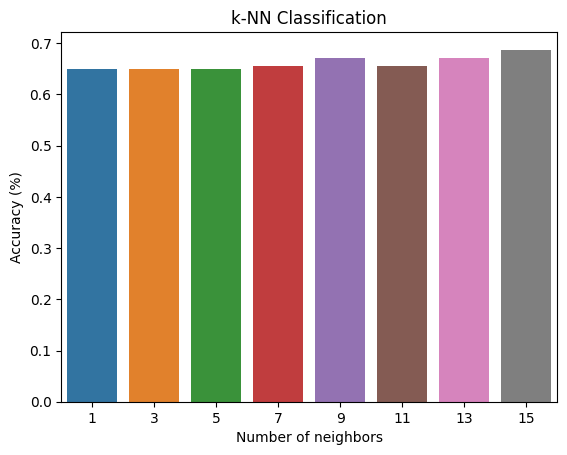

In [ ]:
gfg = sns.barplot(x = n_neighbors,y = accuracy)
gfg.set(xlabel ="Number of neighbors", ylabel = "Accuracy (%)", title ='k-NN Classification')

In [ ]:
#Re-entrenar el modelo con los datos de entrenamiento y validación para el valor de k óptimo
k_opt = n_neighbors[np.argmax(accuracy)]
print(f"El número óptimo de vecinos es {k_opt}")
X_train_test = pd.concat([X_train,X_val],axis=0)
y_train_test = np.hstack([y_train,y_val])

clf = Pipeline(steps=[("preprocessor", StandardScaler()),("classifier", KNeighborsClassifier(n_neighbors=k_opt))])
clf.fit(X_train_test, y_train_test)
#Validar el rendimiento del clasificador con los datos de prueba
accuracy = clf.score(X_test, y_test)

print(f"La tasa de acierto de clasificación en el conjunto de test es {accuracy:0.2f}")

El número óptimo de vecinos es 15
La tasa de acierto de clasificación en el conjunto de test es 0.70
